## 1. 데이터처리

In [ ]:
import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import json
import time

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/X_train.csv', index_col=[0])
X_test = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/X_test.csv', index_col=[0])
y_train = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/y_train.csv', index_col=[0])
y_test = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/y_test.csv', index_col=[0])

word_index_json = open('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/word_index_vocab.json', 'r').read()
word_index_vocab = json.loads(word_index_json)

In [ ]:
X_train_split = X_train['댓글'].apply(list).tolist()
X_test_split = X_test['댓글'].apply(list).tolist()

In [ ]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index_vocab

X_train_sequences = tokenizer.texts_to_sequences(X_train_split)
X_test_sequences = tokenizer.texts_to_sequences(X_test_split)

In [ ]:
train = pad_sequences(X_train_sequences, padding='post', maxlen=400)
test = pad_sequences(X_test_sequences, padding='post', maxlen=400)

In [ ]:
y_train.value_counts()

악플여부
0       56179
1       35676
dtype: int64

In [ ]:
# from imblearn.over_sampling import SMOTE

In [ ]:
# start = time.time()

# smote = SMOTE(random_state=123)
# train_over, y_train_over = smote.fit_sample(train, y_train)

# print("걸린시간 :", time.time() - start)

걸린시간 : 257.852915763855


In [ ]:
train_over = train
y_train_over = y_train

## 2. lightGBM : GridSearchCV

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [ ]:
param_grid = {
    'learning_rate'    : [0.1],
    'num_iterations'   : [1400, 2000],
    'max_depth'        : [10, 15],
    'Metric'           : ['binary'],
    'boosting'         : ['dart']  
}

LGBM = LGBMClassifier()
LGBM_grid = GridSearchCV(LGBM, param_grid=param_grid, cv=cv, scoring='f1', verbose=2)
LGBM_grid.fit(train_over, y_train_over)

print('final params', LGBM_grid.best_params_)
print('best score', LGBM_grid.best_score_)

# final params {'Metric': 'binary', 'boosting': 'dart', 'learning_rate': 0.1, 'max_depth': 15, 'num_iterations': 2000}
# best score 0.8076588623298664


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] Metric=binary, boosting=dart, learning_rate=0.1, max_depth=10, num_iterations=1400 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
print('final params', LGBM_grid.best_params_)
print('best score', LGBM_grid.best_score_)

final params {'Metric': 'binary', 'boosting': 'dart', 'learning_rate': 0.1, 'max_depth': 10, 'num_iterations': 1400}
best score 0.7963017250403392


#3. Test Set 예측

In [ ]:
best_params = {'Metric': 'binary', 
               'boosting': 'dart', 
               'learning_rate': 0.1, 
               'max_depth': 10, 
               'num_iterations': 1400}

In [ ]:
model = LGBMClassifier(Metric         = 'binary',
                       max_depth      = 10,
                       boosting       = 'dart',
                       learning_rate  = 0.1,
                       num_iterations = 1400)
model.fit(train_over, y_train_over)

LGBMClassifier(Metric='binary', boosting='dart', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=10, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=1400, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# 4. AUC 확인

In [ ]:
y_prob  = model.predict_proba(test)[:, 1]
y_class = y_prob > 0.5

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, make_scorer
import matplotlib.pyplot as plt

AUC는? : 0.9018292


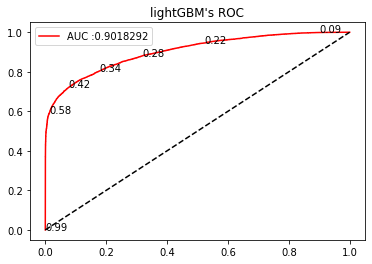

In [ ]:
# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(y_test, y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 1000)


# ROC 그래프 그리기
plt.plot(fpr_array, tpr_array, 
         c = 'red', 
         label = "AUC :" + str(round(roc_auc_score(y_test, y_prob), 7)))
plt.plot([0, 1], [0,1], ls='--', c='black')
plt.title("lightGBM's ROC")
plt.legend(loc=0)
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)


# ROC의 auc는?
print('AUC는? :', round(roc_auc_score(y_test, y_prob), 7))

## 4. ROC 그래프를 그리기위해 저장

In [ ]:
data = {
    'fpr_array'       : fpr_array,
    'tpr_array'       : tpr_array,
    'threshold_array' : threshold_array
}

df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/03_ROC_그래프/lightGBM_ROC.csv')

## 5. 모델 테스트





In [ ]:
import pickle
from sklearn.externals import joblib

In [ ]:
joblib.dump(model, 'lightGBM.pkl')

['lightGBM.pkl']

In [ ]:
def model_test(comment):
    loaded_model = joblib.load('lightGBM.pkl')
    comment_list = [list(comment)]
    comment_label = tokenizer.texts_to_sequences(comment_list)

    comment_pad = pad_sequences(comment_label, padding='post', maxlen=400)

    pred = loaded_model.predict_proba(comment_pad)[:,1]

    if pred < 0.5 :
        result = '악플이 아닙니다'
    else :
        result = '악플입니다'
    
    print(result)
    print('라벨확률 : ', pred)
    
    return result, pred

In [ ]:
comment = '''개새끼야'''

result, prob = model_test(comment)

악플이 아닙니다
라벨확률 :  [0.27372783]
